# Test run WFlow and LISFLOOD together using GLOFRIM

In this notebook we test a one-way coupled run for wflow and lisflood. We particularly focus on whether the coupling locations are as expected as we need to ensure that coordinates are projected from one system (Wflow) to the other correctly. The experiment we setup is a simple one-way coupling where routed WFlow discharge (RiverRunoff) goes to the 1D channels in LISFLOOD-FP of Barotse.

In [1]:
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as img_tiles
import rasterio.warp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys, os
from datetime import datetime
import glofrim.glofrim_lib as glib

# import Glofrim itself
from glofrim import Glofrim


Setup the Glofrim object with the Glofrim .ini file

In [2]:
cbmi = Glofrim()
root_dir = '/home/hcwinsemius/git/barotse/experiments/'
config_fn = os.path.join(root_dir, 'glofrim_barotse_1way1Donly.ini')
cbmi.initialize_config(config_fn) #, env_fn=env_fn)


2020-04-15 17:44:44,159 - GLOFRIM - INFO - Reading ini file..
2020-04-15 17:44:44,371 - GLOFRIM.WFL - INFO - Read ini at /home/hcwinsemius/Barotse/zambezi_4km/wflow_sbm.ini
2020-04-15 17:44:44,376 - wflow_sbm.ini - wf_DynamicFramework - INFO - wflow_sbm.ini 2019.2.dev9+ge8b26553 Case: /home/hcwinsemius/Barotse/zambezi_4km Runid: run_default
2020-04-15 17:44:44,376 - wflow_sbm.ini - wf_DynamicFramework - INFO - Initialise framework version: 2019.2.dev9+ge8b26553
2020-04-15 17:44:44,378 - wflow_sbm.ini - wf_DynamicFramework - WARNING - Ini file made for wflow_sbm but found wflow.wflow_sbm in code.
2020-04-15 17:44:44,379 - GLOFRIM.WFL - INFO - Config initialized
2020-04-15 17:44:44,379 - GLOFRIM.WFL - INFO - Getting rgrid info based on wflow_subcatch.map
2020-04-15 17:44:44,566 - GLOFRIM.WFL - INFO - Getting drainage direction from wflow_ldd.map
2020-04-15 17:44:44,572 - GLOFRIM.LFP - INFO - Config initialized
2020-04-15 17:44:44,573 - GLOFRIM.LFP - INFO - Getting rgrid info based on bfp

Set a start and end time interactively. Now just a couple of days for testing

In [3]:
t_start = datetime(2000,1,1)
t_end = datetime(2000,1,11)
cbmi.set_start_time(t_start)
cbmi.set_end_time(t_end)
try:
    t_start == cbmi.get_start_time()
    t_end == cbmi.get_end_time()
except:
    sys.exit('start or end time differ with set_var and get_var')
print('start time is: {:s}\nEnd time is {:s}'.format(t_start.strftime('%Y-%m-%d %H:%M:%S'), t_end.strftime('%Y-%m-%d %H:%M:%S')))


start time is: 2000-01-01 00:00:00
End time is 2000-01-11 00:00:00


Now initialize the Glofrim coupled model instance

In [4]:
cbmi.initialize_model()

2020-04-15 17:44:44,702 - GLOFRIM - INFO - set coupled grids for: SpatialCoupling object from WFL to LFP based on grid_us_2_1d_us method
2020-04-15 17:44:44,883 - wflow_sbm.ini - wf_DynamicFramework - INFO - Not reading time from ini file, assuming it is set by BMI or otherwise (calls = 3)
2020-04-15 17:44:44,885 - wflow_sbm.ini - wf_netcdfio - INFO - Reading input from netCDF file: /home/hcwinsemius/Barotse/zambezi_4km/inmaps/forcing-2000_2018.nc
2020-04-15 17:44:44,958 - wflow_sbm.ini - wf_netcdfio - WARNING - Variable IF not found in netcdf file: /home/hcwinsemius/Barotse/zambezi_4km/inmaps/forcing-2000_2018.nc
2020-04-15 17:44:44,958 - wflow_sbm.ini - wf_netcdfio - WARNING - Variable IF not found in netcdf file: /home/hcwinsemius/Barotse/zambezi_4km/inmaps/forcing-2000_2018.nc
2020-04-15 17:44:44,962 - wflow_sbm.ini - wf_netcdfio - INFO - Setting up netcdf output: /home/hcwinsemius/Barotse/zambezi_4km/run_default/outmaps.nc
2020-04-15 17:44:44,963 - wflow_sbm.ini - wf_netcdfio - IN

2020-04-15 17:44:45,059 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/TT.tbl
2020-04-15 17:44:45,063 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/TTM.tbl
2020-04-15 17:44:45,067 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/Cfmax.tbl
2020-04-15 17:44:45,072 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/WHC.tbl
2020-04-15 17:44:45,074 - wflow_sbm.ini - wf_DynamicFramework - WARNING - tbl file not found (/home/hcwinsemius/Barotse/zambezi_4km/intbl/w_soil.tbl) returning default value: 0.1125
2020-04-15 17:44:45,091 - wflow_sbm.ini - wflow_sbm - INFO - A total of 0 simple reservoirs and 1 lakes found.
2020-04-15 17:44:45,110 - wflow_sbm.ini - wf_DynamicFramework - WARNING - tbl file not found (/home/hcwinsemius/Ba

With the code below we print what dictionaries are currently inside the cbmi object

In [5]:
cbmi.__dict__

{'bmimodels': OrderedDict([('WFL', <glofrim.wfl_bmi.WFL at 0x7fba091f1320>),
              ('LFP', <glofrim.lfp_bmi.LFP at 0x7fb9cd9054e0>)]),
 'exchanges': [('update', 'WFL'),
  ('exchange',
   {'from_mod': 'WFL',
    'from_vars': ['RiverRunoff', 86400.0],
    'from_unit': ['4', 'unknown'],
    'to_mod': 'LFP',
    'to_vars': ['SGCQin', 86400.0],
    'to_unit': ['m3/s', 'unknown'],
    'coupling': SpatialCoupling object from WFL to LFP based on grid_us_2_1d_us method,
    'name': 'WFL.RiverRunoff_to_LFP.SGCQin'}),
  ('update', 'LFP')],
 '_var_sep': '.',
 '_mult_sep': '*',
 '_ind_sep': '@',
 '_loglevel': 20,
 'logger': <Logger GLOFRIM (INFO)>,
 'wb_logger': <Logger wb (INFO)>,
 'initialized': True,
 'obs': None,
 '_config_fn': '/home/hcwinsemius/git/barotse/experiments/glofrim_barotse_1way1Donly.ini',
 '_root': '/home/hcwinsemius/git/glofrim/tests/model_test_data',
 '_config': <configparser.ConfigParser at 0x7fba091f1a58>,
 '_wb_header': ['time', 'WFL.RiverRunoff_to_LFP.SGCQin'],
 '_dt

Let's check the 'exchanges'. Here we should see the (3) different steps that are done to update the coupled model to the next time step. We see here the following:
1. 'update': 'WFL' - first, Wflow is updated by a single (day) time step.
2. 'exchange': {}  - second, RiverRunoff is exchanged from 'WFL' (Wflow) to 'SGCQin' (Subgrid Channel lateral Inflow) in LFP (LISFLOOD-FP) using a multiplier of 86400. This is to convert RiverRunoff in m3/s to a total amount of m3 in the full time step of one day (i.e. one day holds 86400 seconds). The method 'grid_us_2_1d_us' is used, which means exchanging upstream boundary conditions from a 2D grid domain (grid_us) to upstream boundary conditions in a 1D domain (1d_us).
3. 'update': 'LFP' - third, LISFLOOD is now run for a full day (WITH adaptive time stepping) using the upstream flow from WFlow imposed on upstream points in the domain.

After these steps, the next time step is ready to run, and will also go through all 3 steps.

Let's first investigate where we can find the grid information inside the different model instances. See cell below

In [6]:
# first let's see dictionaries inside WFL
print('WFlow model object:\n')
print(cbmi.bmimodels['WFL'].__dict__)
# the grid is what we're looking for, let's check what's inside
print('\nWFlow grid information:\n')
print(cbmi.bmimodels['WFL'].grid.__dict__)
# 
# the 1D grid is what we're looking for, let's check the 1D elements in there (see '_1d')
print('\nWFlow 1D grid information:\n')
print(cbmi.bmimodels['WFL'].grid._1d.__dict__)
# the 'nodes' hold the information of the 1D grid


WFlow model object:

{'_bmi': <wflow.wflow_bmi.wflowbmi_csdms object at 0x7fb9d3e01048>, 'logger': <Logger GLOFRIM.WFL (INFO)>, '_loglevel': 20, 'initialized': True, 'grid': <glofrim.grids.RGrid object at 0x7fb9cd9056a0>, '_config_fn': '/home/hcwinsemius/Barotse/zambezi_4km/wflow_sbm.ini', '_config': <configparser.ConfigParser object at 0x7fb9cd7d0eb8>, '_datefmt': '%Y-%m-%d %H:%M:%S', '_dt': datetime.timedelta(1), '_startTime': datetime.datetime(2000, 1, 1, 0, 0), '_endTime': datetime.datetime(2000, 1, 11, 0, 0), '_t': datetime.datetime(2000, 1, 1, 0, 0)}

WFlow grid information:

{'transform': Affine(0.03333333333333334, 0.0, 18.366666666666667,
       0.0, 0.033333333333333326, -18.9), 'height': 241, 'width': 239, 'shape': (241, 239), 'bounds': (18.366666666666667, -18.9, 26.333333333333336, -10.866666666666667), 'res': 0.03333333333333333, 'NtoS': True, 'crs': '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs', 'mask': array([[False, False, False, ..., False, False, False],
       

Check the 'coupling' object inside Glofrim, and plot coordinates from one grid to the other in one gerographical plot. The following steps are needed:
- extract the indices of the grids of the 'to' and the 'from' model
- convert these into geographical coordinates using the 'grid' object of the resp. models
- plot the grids in one graph, using the CRS of the grids of the 'to' (LFP) and 'from' (WFL) models.


In [7]:
# extract indices. WFL is 2d grid, LFP 1D
ind_WFL_2D = cbmi.exchanges[1][1]['coupling'].from_ind
ind_LFP_1D = cbmi.exchanges[1][1]['coupling'].to_ind

# convert to coordinates



Text(0, 0.5, 'y UTM 34S [m]')

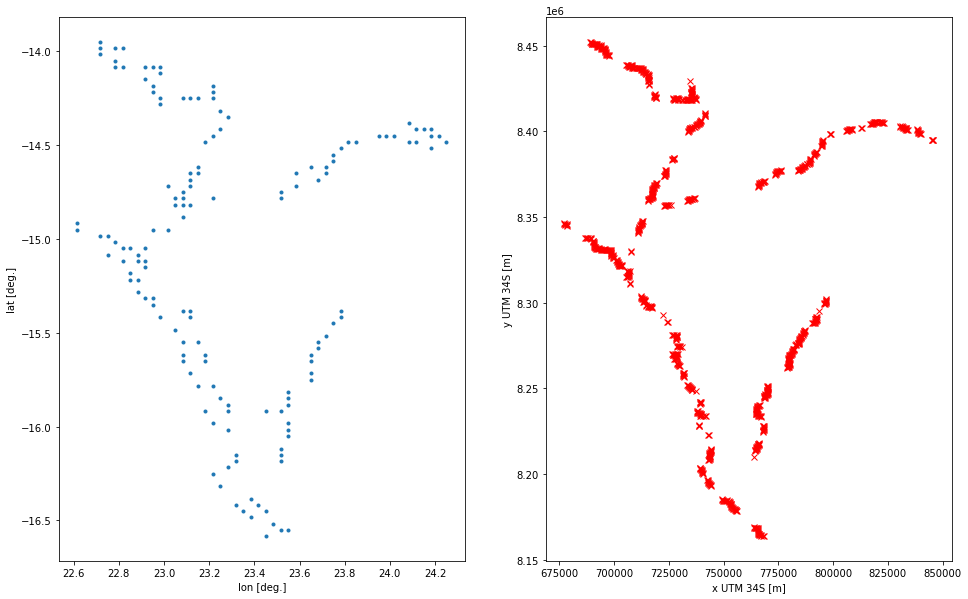

In [8]:
x_from, y_from = cbmi.bmimodels['WFL'].grid.xy(ind_WFL_2D)
x_to, y_to = cbmi.bmimodels['LFP'].grid.xy(ind_LFP_1D)
row_from, col_from = rasterio.transform.rowcol(cbmi.bmimodels['WFL'].grid.transform, x_from, y_from)
# read a streamorder map
s_order_fn = r'/home/hcwinsemius/Barotse/zambezi_4km/staticmaps/wflow_streamorder.map'
with rasterio.open(s_order_fn) as ds:
    s_order = ds.read(1)


f = plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.plot(x_from, y_from, '.')
plt.xlabel('lon [deg.]')
plt.ylabel('lat [deg.]')

plt.subplot(122)
plt.plot(x_to, y_to, 'rx')
plt.xlabel('x UTM 34S [m]')
plt.ylabel('y UTM 34S [m]')



Check the overlap between points in river stream network and the boundary conditions. It seems that there is double counting of flow as multiple entries in the stream network are found iun the same river

(70.0, 145.0)

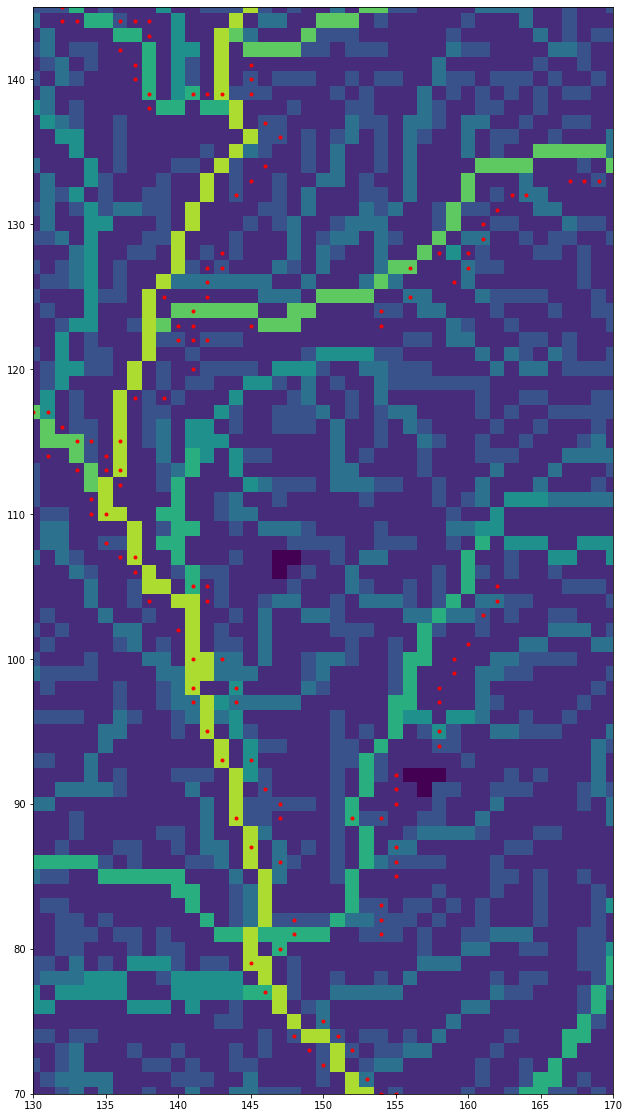

In [9]:
plt.figure(figsize=(15, 20))
# plt.imshow(np.flipud(s_order), vmin=0, origin='lower', interpolation='nearest')
plt.imshow(np.flipud(s_order), origin='lower', vmin=0, interpolation='nearest')
plt.plot(np.array(col_from), np.array(row_from), 'r.')
plt.xlim([130, 170])
plt.ylim([70, 145])

plot these in one geographical figure with a nice mapbox background to check if projections give a match

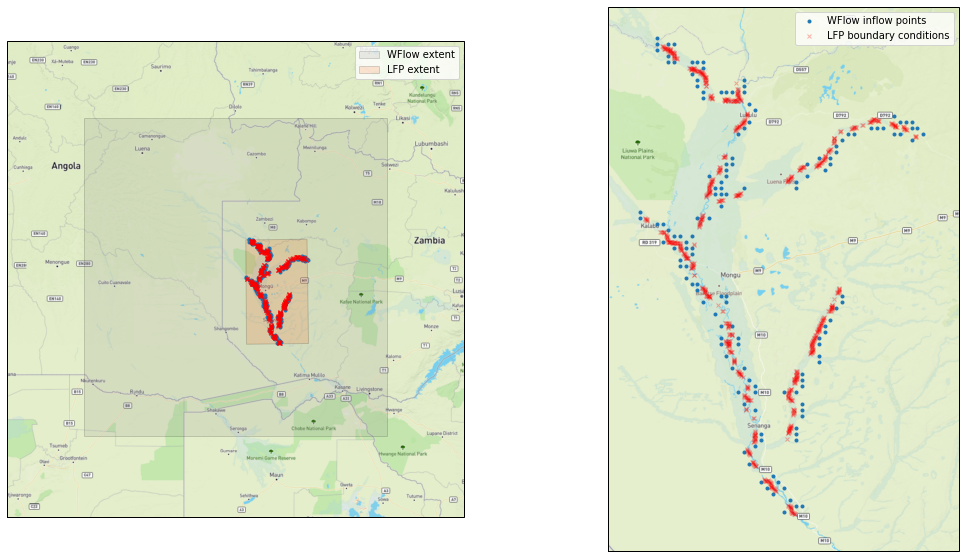

In [10]:
token = 'pk.eyJ1IjoiaGN3aW5zZW1pdXMiLCJhIjoiY2l2MHd3aDN4MDA0OTJ6dDU2Y2F6MWk0dCJ9.mLH0b46r4cHNdb1w9-dLcQ'
outdoor = img_tiles.MapboxStyleTiles(token, 'hcwinsemius', 'ck4ohy7u59mfg1cmi0z2twtll')
f = plt.figure(figsize=(18, 10))

# WFlow
xmin, ymin, xmax, ymax = cbmi.bmimodels['WFL'].grid.bounds
extent_wflow = (xmin-2, xmax+2, ymin-2, ymax+2)
rect_wflow = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='k',facecolor='gray', alpha=0.15, transform=ccrs.PlateCarree(), label='WFlow extent')

# LFP
xmin, ymin, xmax, ymax = cbmi.bmimodels['LFP'].grid.bounds
extent_lfp = (xmin-2e4, xmax+2e4, ymin-2e4, ymax+2e4)
rect_lfp = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='k',facecolor='#FF5500', alpha=0.15, transform=ccrs.UTM(34, southern_hemisphere=True), label='LFP extent')

# start a geographical axis
ax1 = plt.subplot(121, projection=outdoor.crs)
# limit spatial extent to WFlow model lat-lon bounds (note that ccrs.PlateCarree is the same as WGS84 lat lon)
ax1.set_extent(extent_wflow, crs=ccrs.PlateCarree())
ax1.add_image(outdoor, 7, interpolation='bilinear')
ax1.plot(x_from, y_from, '.', transform=ccrs.PlateCarree())
ax1.plot(x_to, y_to, 'rx', markersize=4., alpha=0.3, transform=ccrs.UTM(34, southern_hemisphere=True))
# Add the patch to the Axes
ax1.add_patch(rect_wflow)
ax1.add_patch(rect_lfp)
ax1.legend()

# start a second geographical axis, zoomed to LFP domain
ax2 = plt.subplot(122, projection=outdoor.crs)
# limit spatial extent to WFlow model lat-lon bounds (note that ccrs.PlateCarree is the same as WGS84 lat lon)
ax2.set_extent(extent_lfp, crs=ccrs.UTM(34, southern_hemisphere=True))
ax2.add_image(outdoor, 9, interpolation='bilinear')
ax2.plot(x_from, y_from, '.', transform=ccrs.PlateCarree(), label='WFlow inflow points')
ax2.plot(x_to, y_to, 'rx', markersize=4., alpha=0.3, transform=ccrs.UTM(34, southern_hemisphere=True), label='LFP boundary conditions')
ax2.legend()


TODO: Check how much volume is extracted from Wflow per time step (day), and compare that against the volume inserted in LISFLOOD per day.

TODO: Collect all results in an Xarray DataArray and plot and store them
